In [1]:
## requirements
# conda install --file env/byoml_tensorflow.environment.yml
# conda activate byoml_tensorflow 
# pip install -r env/byoml_tensorflow.requirements.txt

In [2]:
MODEL_NAME='retries-example'
WINDOW=12
TEST_DATA_SIZE = 24

## Retries example based on a TensorFlow model

In this notebook we show how you can create and upload a TensorFlow model to Waylay. We will expect you to save your model using the [SavedModel format](https://www.tensorflow.org/guide/saved_model).
When a model is uploaded to Waylay, it takes a moment to compile the model. After compilation, the model will be available for use. If a request ('get' or 'predict') is done before the model is compiled, a 409 Error will be returned. Python SDK has a standard Retry policy, but this can be configured by the user as they wish. If logging is turned on, more info on each retry will be logged.

First let's import a dataset:

In [3]:
import seaborn as sns
import pandas as pd
import logging

logging.basicConfig(level=logging.ERROR)
logging.getLogger('waylay').setLevel(logging.INFO)

passengers                                                       
month        Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
year                                                                   
1949         112  118  132  129  121  135  148  148  136  119  104  118
1950         115  126  141  135  125  149  170  170  158  133  114  140
1951         145  150  178  163  172  178  199  199  184  162  146  166
1952         171  180  193  181  183  218  230  242  209  191  172  194
1953         196  196  236  235  229  243  264  272  237  211  180  201
1954         204  188  235  227  234  264  302  293  259  229  203  229
1955         242  233  267  269  270  315  364  347  312  274  237  278
1956         284  277  317  313  318  374  413  405  355  306  271  306
1957         315  301  356  348  355  422  465  467  404  347  305  336
1958         340  318  362  348  363  435  491  505  404  359  310  337
1959         360  342  406  396  420  472  548  559  463  407  362  405
1960         417  391  419  461  472  535  622  606  508  461  390  432

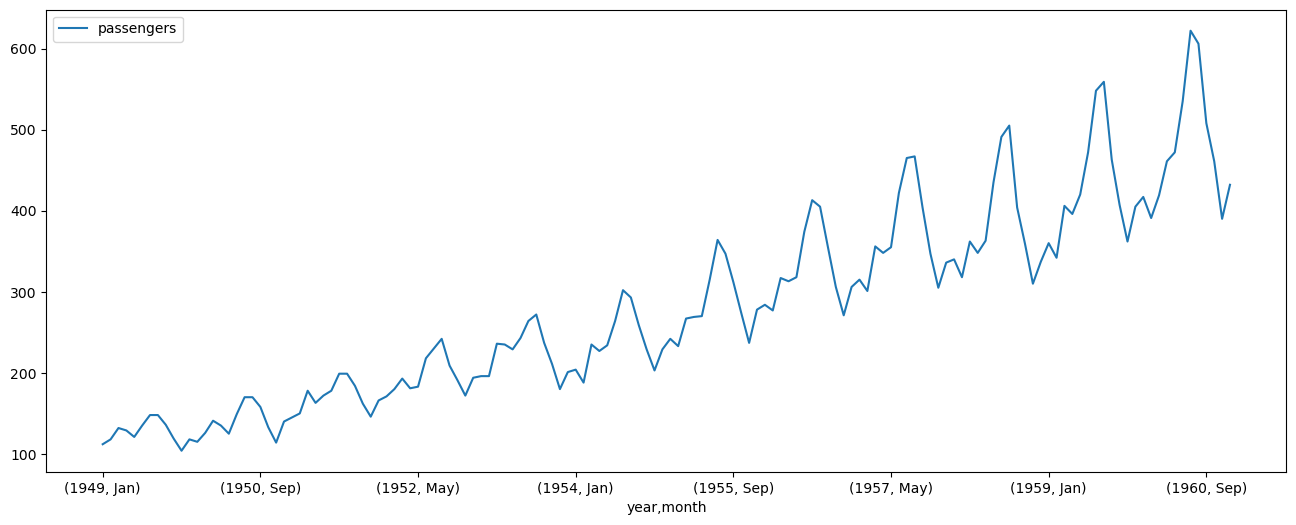

In [4]:
df = sns.load_dataset('flights')
df = df.set_index(['year', 'month'])
df.plot(figsize=(16,6))
df.unstack('month')

In [5]:
import tensorflow as tf
import numpy as np

In [7]:


# features are a sliding window over the last 12 months, predicting the following month
def features_and_labels(input_df, window=WINDOW):
    feat_columns = [ f'+{i}M' for i in range(window) ]
    label_columns = [f'+{window}M']
    index = input_df.index[:len(input_df.index) - window]
    
    ds = tf.data.Dataset.from_tensor_slices(input_df['passengers'].values)
    feat_ds = ds.window(window, shift=1, drop_remainder=True).take(len(index))
    
    df_feat = pd.DataFrame(
        data=(list(w.as_numpy_iterator()) for w in feat_ds), 
        index=index, 
        columns=feat_columns
    )

    df_labels = pd.DataFrame(
        data=input_df.iloc[window:,0].values, 
        index=index, 
        columns=label_columns
    )
    
    return pd.concat([df_feat, df_labels], axis=1, keys=['features','labels'])

df_train = features_and_labels(df.iloc[:-TEST_DATA_SIZE])
display(df_train)
df_test = features_and_labels(df.iloc[-TEST_DATA_SIZE-WINDOW:])

features                                                         \
                +0M  +1M  +2M  +3M  +4M  +5M  +6M  +7M  +8M  +9M +10M +11M   
year month                                                                   
1949 Jan        112  118  132  129  121  135  148  148  136  119  104  118   
     Feb        118  132  129  121  135  148  148  136  119  104  118  115   
     Mar        132  129  121  135  148  148  136  119  104  118  115  126   
     Apr        129  121  135  148  148  136  119  104  118  115  126  141   
     May        121  135  148  148  136  119  104  118  115  126  141  135   
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1957 Aug        467  404  347  305  336  340  318  362  348  363  435  491   
     Sep        404  347  305  336  340  318  362  348  363  435  491  505   
     Oct        347  305  336  340  318  362  348  363  435  491  505  404   
     Nov        305  336  340  318  362  348  363  435  491  505  404  359   
     Dec        336  340  318  362  348  363  435  491  505  404  359  310   

           labels  
             +12M  
year month         
1949 Jan      115  
     Feb      126  
     Mar      141  
     Apr      135  
     May      125  
...           ...  
1957 Aug      505  
     Sep      404  
     Oct      359  
     Nov      310  
     Dec      337  

[108 rows x 13 columns]

In [8]:
X_train = tf.convert_to_tensor(df_train.xs('features',axis=1).values)
y_train = tf.convert_to_tensor(df_train.xs('labels',axis=1).values)
X_test = tf.convert_to_tensor(df_test.xs('features',axis=1).values)
y_test = tf.convert_to_tensor(df_test.xs('labels',axis=1).values)

Now we can create the model, a simple one:

In [9]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1],), name="previous_month"))
model.add(tf.keras.layers.Reshape((X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [10]:
history = model.fit(X_train, y_train,
                    batch_size=4,
                    epochs=1000,
                    verbose=1)

2022-09-05 16:32:00.808176: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/1000
27/27 [==============================] - 1s 3ms/step - loss: 77331.0896
Epoch 2/1000
27/27 [==============================] - 0s 3ms/step - loss: 66921.6412
Epoch 3/1000
27/27 [==============================] - 0s 3ms/step - loss: 81367.6917
Epoch 4/1000
27/27 [==============================] - 0s 3ms/step - loss: 72089.4609
Epoch 5/1000
27/27 [==============================] - 0s 3ms/step - loss: 61646.5423
Epoch 6/1000
27/27 [==============================] - 0s 3ms/step - loss: 65429.5854
Epoch 7/1000
27/27 [==============================] - 0s 3ms/step - loss: 62079.5008
Epoch 8/1000
27/27 [==============================] - 0s 3ms/step - loss: 66136.0158
Epoch 9/1000
27/27 [==============================] - 0s 3ms/step - loss: 61088.3786
Epoch 10/1000
27/27 [==============================] - 0s 3ms/step - loss: 62168.0389
Epoch 11/1000
27/27 [==============================] - 0s 3ms/step - loss: 61788.3864
Epoch 12/1000
27/27 [==============================] - 0s 3ms/s

27/27 [==============================] - 0s 3ms/step - loss: 18785.3996
Epoch 97/1000
27/27 [==============================] - 0s 3ms/step - loss: 20723.7272
Epoch 98/1000
27/27 [==============================] - 0s 3ms/step - loss: 17117.8901
Epoch 99/1000
27/27 [==============================] - 0s 3ms/step - loss: 15433.2502
Epoch 100/1000
27/27 [==============================] - 0s 3ms/step - loss: 15983.5137
Epoch 101/1000
27/27 [==============================] - 0s 3ms/step - loss: 17686.5872
Epoch 102/1000
27/27 [==============================] - 0s 3ms/step - loss: 13769.2729
Epoch 103/1000
27/27 [==============================] - 0s 3ms/step - loss: 15837.8956
Epoch 104/1000
27/27 [==============================] - 0s 3ms/step - loss: 15989.2646
Epoch 105/1000
27/27 [==============================] - 0s 3ms/step - loss: 19960.7104
Epoch 106/1000
27/27 [==============================] - 0s 3ms/step - loss: 13007.3788
Epoch 107/1000
27/27 [==============================] - 0s 3m

27/27 [==============================] - 0s 3ms/step - loss: 4154.9336
Epoch 192/1000
27/27 [==============================] - 0s 2ms/step - loss: 3956.6219
Epoch 193/1000
27/27 [==============================] - 0s 3ms/step - loss: 2771.9579
Epoch 194/1000
27/27 [==============================] - 0s 2ms/step - loss: 2874.8404
Epoch 195/1000
27/27 [==============================] - 0s 2ms/step - loss: 4781.7501
Epoch 196/1000
27/27 [==============================] - 0s 2ms/step - loss: 3205.9487
Epoch 197/1000
27/27 [==============================] - 0s 2ms/step - loss: 3192.9333
Epoch 198/1000
27/27 [==============================] - 0s 2ms/step - loss: 3471.1448
Epoch 199/1000
27/27 [==============================] - 0s 2ms/step - loss: 3473.9533
Epoch 200/1000
27/27 [==============================] - 0s 2ms/step - loss: 3232.0520
Epoch 201/1000
27/27 [==============================] - 0s 2ms/step - loss: 4748.1247
Epoch 202/1000
27/27 [==============================] - 0s 2ms/step -

27/27 [==============================] - 0s 3ms/step - loss: 921.6003
Epoch 287/1000
27/27 [==============================] - 0s 3ms/step - loss: 967.0182
Epoch 288/1000
27/27 [==============================] - 0s 2ms/step - loss: 974.9908
Epoch 289/1000
27/27 [==============================] - 0s 2ms/step - loss: 1475.9178
Epoch 290/1000
27/27 [==============================] - 0s 2ms/step - loss: 805.3388
Epoch 291/1000
27/27 [==============================] - 0s 3ms/step - loss: 969.7024
Epoch 292/1000
27/27 [==============================] - 0s 3ms/step - loss: 1457.4589
Epoch 293/1000
27/27 [==============================] - 0s 3ms/step - loss: 1544.5496
Epoch 294/1000
27/27 [==============================] - 0s 2ms/step - loss: 1130.2804
Epoch 295/1000
27/27 [==============================] - 0s 2ms/step - loss: 1552.2380
Epoch 296/1000
27/27 [==============================] - 0s 2ms/step - loss: 1033.9608
Epoch 297/1000
27/27 [==============================] - 0s 2ms/step - loss

27/27 [==============================] - 0s 3ms/step - loss: 450.7209
Epoch 383/1000
27/27 [==============================] - 0s 3ms/step - loss: 566.9401
Epoch 384/1000
27/27 [==============================] - 0s 3ms/step - loss: 465.8380
Epoch 385/1000
27/27 [==============================] - 0s 4ms/step - loss: 457.4136
Epoch 386/1000
27/27 [==============================] - 0s 4ms/step - loss: 658.9634
Epoch 387/1000
27/27 [==============================] - 0s 4ms/step - loss: 529.2235
Epoch 388/1000
27/27 [==============================] - 0s 4ms/step - loss: 511.2490
Epoch 389/1000
27/27 [==============================] - 0s 3ms/step - loss: 468.0645
Epoch 390/1000
27/27 [==============================] - 0s 3ms/step - loss: 381.4909
Epoch 391/1000
27/27 [==============================] - 0s 3ms/step - loss: 516.3679
Epoch 392/1000
27/27 [==============================] - 0s 3ms/step - loss: 584.6991
Epoch 393/1000
27/27 [==============================] - 0s 3ms/step - loss: 373.

27/27 [==============================] - 0s 4ms/step - loss: 292.0711
Epoch 479/1000
27/27 [==============================] - 0s 5ms/step - loss: 214.9273
Epoch 480/1000
27/27 [==============================] - 0s 4ms/step - loss: 275.6682
Epoch 481/1000
27/27 [==============================] - 0s 4ms/step - loss: 211.5931
Epoch 482/1000
27/27 [==============================] - 0s 4ms/step - loss: 203.6609
Epoch 483/1000
27/27 [==============================] - 0s 4ms/step - loss: 192.3894
Epoch 484/1000
27/27 [==============================] - 0s 4ms/step - loss: 190.8600
Epoch 485/1000
27/27 [==============================] - 0s 4ms/step - loss: 271.5246
Epoch 486/1000
27/27 [==============================] - 0s 4ms/step - loss: 194.0239
Epoch 487/1000
27/27 [==============================] - 0s 4ms/step - loss: 299.5818
Epoch 488/1000
27/27 [==============================] - 0s 4ms/step - loss: 213.2610
Epoch 489/1000
27/27 [==============================] - 0s 4ms/step - loss: 183.

27/27 [==============================] - 0s 3ms/step - loss: 134.8390
Epoch 575/1000
27/27 [==============================] - 0s 3ms/step - loss: 103.9028
Epoch 576/1000
27/27 [==============================] - 0s 3ms/step - loss: 126.2538
Epoch 577/1000
27/27 [==============================] - 0s 3ms/step - loss: 127.3425
Epoch 578/1000
27/27 [==============================] - 0s 3ms/step - loss: 195.3782
Epoch 579/1000
27/27 [==============================] - 0s 3ms/step - loss: 318.3788
Epoch 580/1000
27/27 [==============================] - 0s 3ms/step - loss: 176.3475
Epoch 581/1000
27/27 [==============================] - 0s 3ms/step - loss: 192.7508
Epoch 582/1000
27/27 [==============================] - 0s 3ms/step - loss: 244.8548
Epoch 583/1000
27/27 [==============================] - 0s 3ms/step - loss: 156.9649
Epoch 584/1000
27/27 [==============================] - 0s 3ms/step - loss: 164.6699
Epoch 585/1000
27/27 [==============================] - 0s 3ms/step - loss: 116.

27/27 [==============================] - 0s 3ms/step - loss: 100.4653
Epoch 671/1000
27/27 [==============================] - 0s 3ms/step - loss: 163.2571
Epoch 672/1000
27/27 [==============================] - 0s 3ms/step - loss: 150.5046
Epoch 673/1000
27/27 [==============================] - 0s 3ms/step - loss: 88.9807
Epoch 674/1000
27/27 [==============================] - 0s 3ms/step - loss: 59.6295
Epoch 675/1000
27/27 [==============================] - 0s 3ms/step - loss: 62.0788
Epoch 676/1000
27/27 [==============================] - 0s 3ms/step - loss: 60.3655
Epoch 677/1000
27/27 [==============================] - 0s 3ms/step - loss: 64.4839
Epoch 678/1000
27/27 [==============================] - 0s 3ms/step - loss: 70.4340
Epoch 679/1000
27/27 [==============================] - 0s 3ms/step - loss: 83.1415
Epoch 680/1000
27/27 [==============================] - 0s 3ms/step - loss: 79.3332
Epoch 681/1000
27/27 [==============================] - 0s 3ms/step - loss: 61.5721
Epoc

27/27 [==============================] - 0s 3ms/step - loss: 73.6121
Epoch 768/1000
27/27 [==============================] - 0s 3ms/step - loss: 56.8161
Epoch 769/1000
27/27 [==============================] - 0s 3ms/step - loss: 116.2570
Epoch 770/1000
27/27 [==============================] - 0s 3ms/step - loss: 60.5063
Epoch 771/1000
27/27 [==============================] - 0s 3ms/step - loss: 33.6066
Epoch 772/1000
27/27 [==============================] - 0s 3ms/step - loss: 38.1093
Epoch 773/1000
27/27 [==============================] - 0s 3ms/step - loss: 77.7756
Epoch 774/1000
27/27 [==============================] - 0s 3ms/step - loss: 120.6086
Epoch 775/1000
27/27 [==============================] - 0s 3ms/step - loss: 144.9418
Epoch 776/1000
27/27 [==============================] - 0s 3ms/step - loss: 142.3949
Epoch 777/1000
27/27 [==============================] - 0s 3ms/step - loss: 103.4319
Epoch 778/1000
27/27 [==============================] - 0s 3ms/step - loss: 181.3162
E

27/27 [==============================] - 0s 3ms/step - loss: 70.8795
Epoch 865/1000
27/27 [==============================] - 0s 3ms/step - loss: 96.1703
Epoch 866/1000
27/27 [==============================] - 0s 3ms/step - loss: 56.9811
Epoch 867/1000
27/27 [==============================] - 0s 3ms/step - loss: 82.6606
Epoch 868/1000
27/27 [==============================] - 0s 3ms/step - loss: 41.2355
Epoch 869/1000
27/27 [==============================] - 0s 3ms/step - loss: 87.1630
Epoch 870/1000
27/27 [==============================] - 0s 3ms/step - loss: 61.0749
Epoch 871/1000
27/27 [==============================] - 0s 3ms/step - loss: 43.9466
Epoch 872/1000
27/27 [==============================] - 0s 3ms/step - loss: 74.1534
Epoch 873/1000
27/27 [==============================] - 0s 3ms/step - loss: 57.6677
Epoch 874/1000
27/27 [==============================] - 0s 3ms/step - loss: 40.2158
Epoch 875/1000
27/27 [==============================] - 0s 3ms/step - loss: 70.2018
Epoch 8

27/27 [==============================] - 0s 3ms/step - loss: 46.2684
Epoch 962/1000
27/27 [==============================] - 0s 3ms/step - loss: 31.6747
Epoch 963/1000
27/27 [==============================] - 0s 3ms/step - loss: 28.8449
Epoch 964/1000
27/27 [==============================] - 0s 3ms/step - loss: 29.4982
Epoch 965/1000
27/27 [==============================] - 0s 3ms/step - loss: 33.3398
Epoch 966/1000
27/27 [==============================] - 0s 3ms/step - loss: 33.0956
Epoch 967/1000
27/27 [==============================] - 0s 3ms/step - loss: 20.9041
Epoch 968/1000
27/27 [==============================] - 0s 3ms/step - loss: 28.9859
Epoch 969/1000
27/27 [==============================] - 0s 3ms/step - loss: 27.3481
Epoch 970/1000
27/27 [==============================] - 0s 3ms/step - loss: 29.8961
Epoch 971/1000
27/27 [==============================] - 0s 3ms/step - loss: 27.2396
Epoch 972/1000
27/27 [==============================] - 0s 3ms/step - loss: 25.4721
Epoch 9

Let's validate if the model learned something:

<AxesSubplot:xlabel='year,month'>

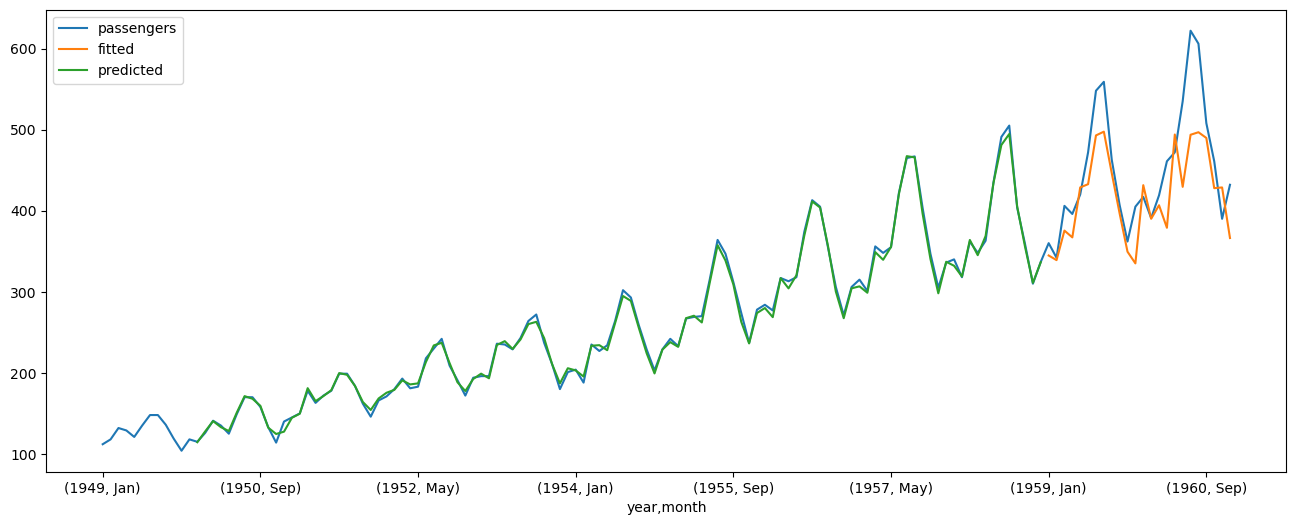

In [11]:
df_pred = df.copy()
df_pred['fitted'] = np.NaN
df_pred['predicted'] = np.NaN
df_pred.iloc[-TEST_DATA_SIZE:,1] = model.predict(X_test)
df_pred.iloc[WINDOW:-TEST_DATA_SIZE,2] =  model.predict(X_train)

df_pred.plot(figsize=(16,6))

## Save the model and upload 

We will save the model in SavedModel format and then upload it to Waylay. 

In [14]:
from waylay import WaylayClient, RestResponseError
import tempfile

waylay = WaylayClient.from_profile('io')

In [15]:
waylay.config

<WaylayConfig({"credentials": {"type": "client_credentials", "api_key": "86724b383e6318ae2551de28", "api_secret": "********", "gateway_url": "https://api-io.waylay.io", "accounts_url": "https://accounts-api-io.waylay.io"}, "profile": "io", "settings": {}})>

There are many other ways to create a SavedModel, for example using [Estimators](https://www.tensorflow.org/guide/estimator#savedmodels_from_estimators) or using a custom [Module](https://www.tensorflow.org/guide/saved_model#saving_a_custom_model), all follow the same flow to upload the model to Waylay. Just pass the directory where you saved your model to the SDK and we will do the rest.

In [16]:
# clean up existing model
import time
try:
    waylay.byoml.model.remove(MODEL_NAME)
    display(f'Removed: {MODEL_NAME}')
except RestResponseError as e:
    display(f'Ignored: {e}')

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=DELETE;status_code=200;dur=241.331


'Removed: retries-example'

In [17]:
result = waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='tensorflow', 
    description='tensorflow example'
)

result

2022-09-05 16:33:43.457395: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=POST;status_code=200;dur=3714.731


{'createdOn': '2021-01-04T00:00:00+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.4',
 'message': 'Model successfully uploaded',
 'metadata': {'description': 'tensorflow example'},
 'name': 'retries-example',
 'updatedOn': '2021-01-04T00:00:00+00:00',
 'version': '1'}

After upload, it can take a few seconds before the model is available for execution.

This can be seen when by inspecting the `ready` property when retrieving the model.

In [18]:
try:
    result = waylay.byoml.model.get(MODEL_NAME)
    display(result)
except Exception as e:
    display(e)

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=GET;status_code=200;dur=2020.216


{'createdBy': 'users/6d686630-0771-4f92-8c63-c888146c33fc',
 'createdOn': '2022-09-05T14:33:47.137000+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.4',
 'metadata': {'description': 'tensorflow example'},
 'name': 'retries-example',
 'ready': False,
 'supported_endpoints': [],
 'updatedBy': 'users/6d686630-0771-4f92-8c63-c888146c33fc',
 'updatedOn': '2022-09-05T14:33:50.025000+00:00',
 'version': '1'}

For resources such as a BYOML model, you can poll until the deployment is ready by including the `retry_until_ready` flag.

In [19]:
try:
    result = waylay.byoml.model.get(MODEL_NAME, retry_until_ready=True)
    display(result)
except Exception as e:
    display(e)

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=GET;status_code=200;dur=2020.712
INFO:waylay.byoml.model.get:Retrying byoml.model.get in 4.0 seconds as it raised Model is not ready yet..
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=GET;status_code=200;dur=2214.234
INFO:waylay.byoml.model.get:Retrying byoml.model.get in 4.0 seconds as it raised Model is not ready yet..
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=GET;status_code=200;dur=2021.327
INFO:waylay.byoml.model.get:Retrying byoml.model.get in 4.0 seconds as it raised Model is not ready yet..
INFO:waylay.service.byoml.model.server-timing:monito

{'createdBy': 'users/6d686630-0771-4f92-8c63-c888146c33fc',
 'createdOn': '2022-09-05T14:33:47.137000+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.4',
 'metadata': {'description': 'tensorflow example'},
 'name': 'retries-example',
 'ready': True,
 'supported_endpoints': ['predict'],
 'updatedBy': 'users/6d686630-0771-4f92-8c63-c888146c33fc',
 'updatedOn': '2022-09-05T14:33:50.025000+00:00',
 'version': '1'}

When making predictions, retry handling will also wait until the model is ready:

In [20]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy())
    display(predictions[:3])
except Exception as e:
    display(e)
    

INFO:waylay.service.byoml.model.server-timing:billing/byoml.predict;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=POST;status_code=200;dur=1323.874
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=POST;status_code=200;dur=1337.626


[[344.785736], [339.050537], [375.481964]]

You can provide additional parameters to influence the retry behaviour:
* `retry_attempts=20`   : Maximal number of retries.
* `retry_max_delay=120` : Maximal delay in seconds.
* `timeout`             : Maximal number of seconds that the client will wait for one attempt. This parameter is available on most Python SDK calls.

In [21]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy(), retry_attempts=1, retry_max_delay=1)
    display(predictions[:3])
except Exception as e:
    display(e)
    

INFO:waylay.service.byoml.model.server-timing:billing/byoml.predict;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=POST;status_code=200;dur=9.304
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=POST;status_code=200;dur=24.870


[[344.785736], [339.050537], [375.481964]]

In [22]:
try:
    waylay.byoml.model.remove(MODEL_NAME)
except Exception as e:
    display(f'{e}')

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=DELETE;status_code=200;dur=132.673


Retry behaviour won't be triggered by non-existing resources, but only on responses with specific HTTP status codes (`409`, `429`, `500`, `502`, `503`, `504`, `508`). The _NOT FOUND_ `404` error will just be forwarded to the user:


In [23]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy())
    display(predictions[:3])
except Exception as e:
    display(e)

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=POST;status_code=404;dur=13.571


waylay.service.byoml._exceptions.ByomlActionError('operation=not_found_error')

In [24]:
result = waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='tensorflow', 
    description='tensorflow example',
    timeout=300
)

result

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=POST;status_code=409;dur=214.267
INFO:waylay.byoml.model._create:Retrying byoml.model._create in 4.0 seconds as it raised ByomlActionError(409: 'A plug with this name and version has not been completely removed yet. Please retry later.'; POST 'https://api-io.waylay.io/ml/v1/models').
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=POST;status_code=409;dur=228.452
INFO:waylay.byoml.model._create:Retrying byoml.model._create in 4.0 seconds as it raised ByomlActionError(409: 'A plug with this name and version has not been completely removed yet. Please retry later.'; POST 'https://api-io.waylay.io/ml/v1/models').
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models;environment=production

{'createdOn': '2021-01-04T00:00:00+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.4',
 'message': 'Model successfully uploaded',
 'metadata': {'description': 'tensorflow example'},
 'name': 'retries-example',
 'updatedOn': '2021-01-04T00:00:00+00:00',
 'version': '1'}

We immediately try prediction on the new model with a low `timeout=5` and `retry_attempts = 1`: this should fail as the endpoint will not be ready.

In [25]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy(), timeout=5, retry_attempts = 1)
    display(predictions[:3])
except Exception as e:
    display(e)
    


ERROR:simple_rest_client.decorators:The read operation timed out
Traceback (most recent call last):
  File "/Users/thomas/miniconda3/envs/byoml_tensorflow24/lib/python3.7/site-packages/httpcore/_exceptions.py", line 8, in map_exceptions
    yield
  File "/Users/thomas/miniconda3/envs/byoml_tensorflow24/lib/python3.7/site-packages/httpcore/backends/sync.py", line 26, in read
    return self._sock.recv(max_bytes)
  File "/Users/thomas/miniconda3/envs/byoml_tensorflow24/lib/python3.7/ssl.py", line 1056, in recv
    return self.read(buflen)
  File "/Users/thomas/miniconda3/envs/byoml_tensorflow24/lib/python3.7/ssl.py", line 931, in read
    return self._sslobj.read(len)
socket.timeout: The read operation timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/thomas/miniconda3/envs/byoml_tensorflow24/lib/python3.7/site-packages/httpx/_transports/default.py", line 60, in map_httpcore_exceptions
    yield
  File "/User

waylay.exceptions.RestConnectionError(simple_rest_client.exceptions.ClientConnectionError(httpx.ReadTimeout('The read operation timed out')))

Calling without extra parameters should normally wait/retry long enough for succesfull results.

In [26]:
predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy())
display(predictions[:3])

INFO:waylay.service.byoml.model.server-timing:no-server-timing-available;dur=0.030
INFO:waylay.byoml.model.predict:Retrying byoml.model.predict in 4.0 seconds as it raised ByomlActionError(502: 'operation=server_error'; POST 'https://api-io.waylay.io/ml/v1/models/retries-example/predict').
INFO:waylay.service.byoml.model.server-timing:no-server-timing-available;dur=0.030
INFO:waylay.byoml.model.predict:Retrying byoml.model.predict in 4.0 seconds as it raised ByomlActionError(502: 'operation=server_error'; POST 'https://api-io.waylay.io/ml/v1/models/retries-example/predict').
INFO:waylay.service.byoml.model.server-timing:billing/byoml.predict;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=POST;status_code=200;dur=8.990
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=POST;status_code=200;dur=23.792


[[344.785736], [339.050537], [375.481964]]

In [27]:
waylay.byoml.model.remove(MODEL_NAME)

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=66417857-9f49-4a83-9307-e12ad5fbda45;domain=io-testing.waylay.io;method=DELETE;status_code=200;dur=264.380


{'message': 'Model retries-example: all versions deleted',
 'name': 'retries-example',
 'versions': ['0.0.1']}